# Imports

In [1]:
import pandas as pd
from collections import Counter
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import RepeatedStratifiedKFold
from numpy import mean
from numpy import std
from nltk import word_tokenize          
from sklearn.metrics import accuracy_score
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
nltk.download('punkt')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english')) 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mahamfaisalkhan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# reading_dataset
df = pd.read_csv('eeconscia_ws_austin_dataset.csv')

Emission = Activity x Emission Factor

# Defining functions

In [3]:
# Defining a function to remove punctuation, lemmatize using wordnet lemmas 

class LemmaTokenizer:
    ignore_tokens = [',', '.', ';', ':', '"', '``', "''","''", '`', '(', ')','#','@','$','^','!','%','*','&','/','-']
    wordlist = list(set(ignore_tokens).union(stop_words))
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc) if t not in self.wordlist]

# Exploration and Visualization

In [4]:
# Visualizing first few rows
df.head()

,PO_NUMBER,CONTRACT_NAME,EXTENDED_DESCRIPTION,COMMODITY_CODE,COMMODITY_DESCRIPTION,QUANTITY,UNIT_OF_MEASURE,UNIT_OF_MEAS_DESC,UNIT_PRICE,TOTAL_PRICE,VENDOR_NAME,VENDOR_CITY,VENDOR_COUNTRY,LINKEDIN_INDUSTRY
0,DOM1100MAX43377,Critical materials Supply Arrangement,"TRANSFORMER, DISTRIBUTION, SINGLE PHASE, POLE ...",28586,"Transformers, Power Distribution (Incl. Fluid ...",2.0,EA,Each,1640.00,3280.00,TECHLINE INC,AUSTIN,US,Utilities
1,DOM1100MAX41029,forecasted jobs,"TRANSFORMER, PAD-MOUNTED, 3 PHASE, FEED THRU S...",28586,"Transformers, Power Distribution (Incl. Fluid ...",2.0,EA,Each,10036.62,20073.24,TECHLINE INC,AUSTIN,US,Utilities
2,CTM1100MAX41813,Replace Damaged Streetlight Poles,RFQAPC0709 prmax49528 Steel Pole TxDOT #ST40T...,2858058,"POLES, STREETLIGHT, GALV. STEEL",2.0,EA,Each,1258.00,2516.00,KBS ELECTRICAL DISTRIBUTORS INC,AUSTIN,US,Oil & Energy
3,PO220012060605050,material needed at gbsc,RC LN_____ QTY DEL_____ P/F_____ B/O______ DEL...,65933143001,COUPLING BRASS Y-BRANCH 1 1/2MIPT X 1IN X 1IN ...,20.0,EA,Each,44.00,880.00,ACT PIPE & SUPPLY INC,PFLUGERVILLE,US,Wholesale
4,PO220011012502514,material needed at awgbsc,RC LN_____ QTY DEL_____ P/F_____ B/O_____ DEL ...,64050100004,CUP PAPER COATED HOT/COLD SAFETY DESIGN 6 OZ,3.0,CASE,Case,66.40,199.20,GULF COAST PAPER CO INC,AUSTIN,US,Business Supplies & Equipment


In [5]:
# Extended description, unit of measure and unit of description have most null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76531 entries, 0 to 76530
Data columns (total 14 columns):
PO_NUMBER                76531 non-null object
CONTRACT_NAME            76531 non-null object
EXTENDED_DESCRIPTION     61535 non-null object
COMMODITY_CODE           76531 non-null object
COMMODITY_DESCRIPTION    76531 non-null object
QUANTITY                 76531 non-null float64
UNIT_OF_MEASURE          64727 non-null object
UNIT_OF_MEAS_DESC        64727 non-null object
UNIT_PRICE               76531 non-null float64
TOTAL_PRICE              76531 non-null float64
VENDOR_NAME              76531 non-null object
VENDOR_CITY              76024 non-null object
VENDOR_COUNTRY           76024 non-null object
LINKEDIN_INDUSTRY        76531 non-null object
dtypes: float64(3), object(11)
memory usage: 8.2+ MB


In [62]:
# There is quite a lot of variability in these values
df.describe()

,QUANTITY,UNIT_PRICE,TOTAL_PRICE
count,7.601400e+04,7.601400e+04,7.601400e+04
mean,3.903047e+02,6.730788e+02,5.917401e+03
std,7.915961e+03,1.849558e+04,4.497635e+04
min,0.000000e+00,0.000000e+00,4.000000e-02
25%,2.000000e+00,1.310000e+00,1.323000e+02
50%,1.200000e+01,1.198000e+01,4.690000e+02
75%,6.000000e+01,5.600000e+01,2.493778e+03
max,1.912107e+06,3.157355e+06,3.384960e+06


In [7]:
# Most entries are US
df['VENDOR_COUNTRY'].value_counts(dropna=False)

US     76014
NaN      507
CA        10
Name: VENDOR_COUNTRY, dtype: int64

In [10]:
# 99 % of values are US
mean(df['VENDOR_COUNTRY']=='US')

0.9932445675608577

In [8]:
# Not all commodity codes map onto the same description
df.groupby('COMMODITY_CODE').nunique()['COMMODITY_DESCRIPTION'].sort_values()

COMMODITY_CODE
00505          1
5951017        1
59515          1
59540          1
5956072        1
              ..
20015100002    4
48586100002    4
34532690005    4
20015311001    4
20015311002    4
Name: COMMODITY_DESCRIPTION, Length: 4021, dtype: int64

In [9]:
# There seems to be an open spread in the data
df['LINKEDIN_INDUSTRY'].value_counts()

Business Supplies & Equipment    23784
Utilities                        21400
Construction                     11140
Wholesale                        10688
Oil & Energy                      9519
Name: LINKEDIN_INDUSTRY, dtype: int64

In [11]:
# There are lots of cities, with most values in the first 10 cities
df['VENDOR_CITY'].value_counts()

AUSTIN          49754
Round Rock       4020
HOUSTON          2929
Austin           2614
GEORGETOWN       2262
                ...  
ROCKDALE            1
LA HABRA            1
MARBLE FALLS        1
Sweet Valley        1
Toronto             1
Name: VENDOR_CITY, Length: 231, dtype: int64

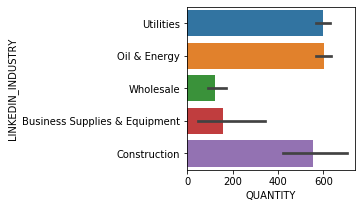

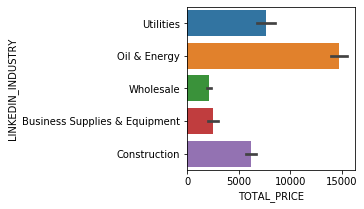

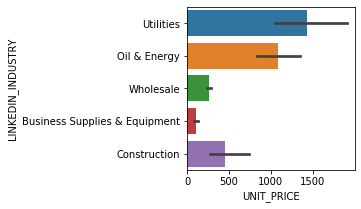

In [12]:
# Total price may be a reliable predictor of industry, but has a lot of variability within industry categories
cols = ['QUANTITY','TOTAL_PRICE','UNIT_PRICE']
for i in cols:
    plt.figure(figsize=(3,3))
    sns.barplot(x=df[i],y=df['LINKEDIN_INDUSTRY'])
    plt.show()

In [13]:
# There is large variability in units of measure
df['UNIT_OF_MEASURE'].value_counts()

EA      43821
FT       5060
TON      4137
CASE     2611
PR       1864
GAL      1734
PK       1263
RL        797
BOX       794
PKG       501
KIT       372
DOL       258
CAN       213
MFT       210
LOT       189
CUYD      131
SET       129
LB        110
DZ        106
BAG       105
DRUM       79
COIL       62
LNFT       32
CYL        32
CART       25
PAIL       21
BTL        18
SHT        15
HOUR       13
QT          9
SQFT        2
YD          2
BNDL        2
M           2
BALE        2
L           1
BULK        1
REEL        1
PT          1
BK          1
DEL         1
Name: UNIT_OF_MEASURE, dtype: int64

# Training model

In [32]:
# Using US only, dropping nulls and Canada
df = df[df['VENDOR_COUNTRY']=='US']

## Training based on commodity_description

### modeling with tfidf

In [49]:
# Separating prediction labels from input dataset
y = df['LINKEDIN_INDUSTRY']

In [50]:
tokenizer=LemmaTokenizer()
token_stop = tokenizer(' '.join(stop_words))
vectorizer = TfidfVectorizer(tokenizer=tokenizer,stop_words=token_stop,ngram_range=(1,1))
X_11 = vectorizer.fit_transform(df['COMMODITY_DESCRIPTION'].str.lower())
X_11 = pd.DataFrame(X_11.toarray(),columns=vectorizer.get_feature_names())

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_11, y, test_size=0.33, random_state=42)

In [36]:
## with sag solver
model = LogisticRegression(multi_class='multinomial', solver='sag')
model.fit(X_train,y_train)
y_pred = model.predict(X_train)
accuracy_score(y_train,y_pred)

0.890258988002906

In [38]:
y_pred_test = model.predict(X_test)
print(accuracy_score(y_test,y_pred_test))
temp = pd.DataFrame(list(zip(y_test,y_pred_test)),columns = ['Actual','Predicted'])
temp['Accuracy'] = 1 * (temp['Actual']==temp['Predicted'])
temp.groupby('Actual').agg({'Accuracy':'sum','Predicted':'count'})
temp.groupby('Actual').mean()

,Accuracy
Actual,
Business Supplies & Equipment,0.951188
Construction,0.933900
Oil & Energy,0.637942
Utilities,0.914078
Wholesale,0.812912


In [63]:
cv = KFold(n_splits=5, random_state=1, shuffle=True)

In [ ]:
model = LogisticRegression(multi_class='multinomial', solver='sag')
scores = cross_val_score(model, X_11, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

### Separating oil and energy

In [43]:
# Separating prediction labels from input dataset
no_oil = df[df['LINKEDIN_INDUSTRY']!='Oil & Energy']
y_no_oil = no_oil['LINKEDIN_INDUSTRY']

In [44]:
tokenizer=LemmaTokenizer()
token_stop = tokenizer(' '.join(stop_words))
vectorizer = TfidfVectorizer(tokenizer=tokenizer,stop_words=token_stop,ngram_range=(1,1))
X_11_no_oil = vectorizer.fit_transform(no_oil['COMMODITY_DESCRIPTION'].str.lower())
X_11_no_oil = pd.DataFrame(X_11_no_oil.toarray(),columns=vectorizer.get_feature_names())

In [45]:
model = LogisticRegression(multi_class='multinomial', solver='lbfgs') #'newton-cg','sag','saga'
model.fit(X_11_no_oil,y_no_oil)
y_pred = model.predict(X_11_no_oil)
accuracy_score(y_no_oil,y_pred)

/Users/mahamfaisalkhan/anaconda3/envs/wbg/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9389309536686498

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X_11_no_oil, y_no_oil, test_size=0.33, random_state=42)

In [47]:
model = LogisticRegression(multi_class='multinomial', solver='sag')
model.fit(X_train,y_train)
y_pred = model.predict(X_train)
accuracy_score(y_train,y_pred)

0.939076619503554

In [48]:
y_pred_test = model.predict(X_test)
accuracy_score(y_test,y_pred_test)

0.9302590249009879

In [49]:
temp = pd.DataFrame(list(zip(y_test,y_pred_test)),columns = ['Actual','Predicted'])
temp['Accuracy'] = 1 * (temp['Actual']==temp['Predicted'])
temp.groupby('Actual').agg({'Accuracy':'sum','Predicted':'count'})
temp.groupby('Actual').mean()

,Accuracy
Actual,
Business Supplies & Equipment,0.954091
Construction,0.936833
Utilities,0.955975
Wholesale,0.822487


### Understanding oil and energy features

In [ ]:
y=df['LINKEDIN_INDUSTRY']

In [51]:
industry = X_11.copy()
industry['industry'] = y.values

In [53]:
for i in y.unique():
    temp = industry[industry['industry']==i][industry.columns[:-1]].sum().sort_values(ascending=False)
    print(i)
    print(temp.head(20).sort_index())
    print()

Utilities
anchor           652.100347
arm              728.221477
bolt             760.178174
brace            767.994728
cable           1500.288453
conduit          500.497100
distribution     812.489445
electrical       523.468798
embedded         420.220176
fill             812.270596
fluid            812.201587
hardware         679.092131
incl             811.522751
line             900.373748
pole            1624.963433
power           1286.881550
steel           1124.292968
transformer      872.222946
type            1565.458473
xlpe             661.977389
dtype: float64

Oil & Energy
asphalt         1324.477005
cable            202.821364
conduit          189.168327
distribution     322.123160
e10              258.786416
e85              253.923046
emulsion        1334.726925
ethanol          457.272035
fill             322.150529
fluid            322.123160
fuel             381.346563
fuse             294.588660
incl             321.741046
line             185.924784
lubricant

### modeling without certain words

In [57]:
cols = X_11.columns[~X_11.columns.isin(['cable','conduit','distribution','fill','fliud','pole','transformer','power'])]
X_ex = X_11[cols]

In [58]:
## with sag solver
model = LogisticRegression(multi_class='multinomial', solver='sag')
model.fit(X_ex,y)
y_pred = model.predict(X_ex)
accuracy_score(y,y_pred)

0.8901518141395006

In [61]:
temp = pd.DataFrame(list(zip(y_pred,y)),columns = ['Actual','Predicted'])
temp['Accuracy'] = 1 * (temp['Actual']==temp['Predicted'])
temp.groupby('Actual').agg({'Accuracy':'sum','Predicted':'count'})
temp.groupby('Actual').mean()

,Accuracy
Actual,
Business Supplies & Equipment,0.948200
Construction,0.955280
Oil & Energy,0.848917
Utilities,0.845998
Wholesale,0.820122
